# 0) Initial Analysis and Preprocessing.

In [1]:
# Import libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pywt

from scipy.signal import welch
from scipy.stats import skew, kurtosis, shapiro, anderson, normaltest, kstest
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

The first thing we did is to visualize the dataset to understand its structure. As we previously explained, each sample consists of 178 features, representing a time series of EEG signal values recorded over a 1-second window. The last column (`y`) is the class label, indicating whether the sample corresponds to seizure activity (**1**) or non-seizure activity (**2, 3, 4, or 5**).  

Since EEG signals are inherently temporal, observing the raw values will help us understand their characteristics before feature engineering and model training.

In [2]:
data = pd.read_csv("data/Epileptic Seizure Recognition.csv")
data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


During the initial exploration of the dataset, we identified an **Unnamed column** that contains no useful information. To ensure clean and structured data, we will drop this column before proceeding with further analysis.

In [3]:
data.drop('Unnamed', axis=1, inplace=True)

## Missing Values  

Handling missing values is an essential step in data preprocessing, as they can lead to biases, reduce model performance, and affect the reliability of predictions. Missing data often requires imputation or removal to ensure consistency and prevent errors in downstream analysis.  

In [4]:
data.any().isna().any()

False

Fortunately, after checking for missing (`NaN`) values, we confirmed that our dataset is **fully clean**, meaning we can proceed without any additional handling for missing data.

## Checking Class Imbalance

Since we are performing a **binary classification task**, we define seizure activity (`y = 1`) as the **positive class**, while all other classes (`y = 2, 3, 4, 5`) represent non-seizure activity. To simplify the classification process, we relabeled all non-seizure samples as negative (`y = 0`). This transformation ensures that our task remains focused on distinguishing seizure events from normal or non-epileptic conditions.  

In [6]:
class_relabeling = {1:1, 2:0, 3:0, 4:0, 5:0}
data.replace({'y': class_relabeling}, inplace=True)

<Axes: xlabel='y'>

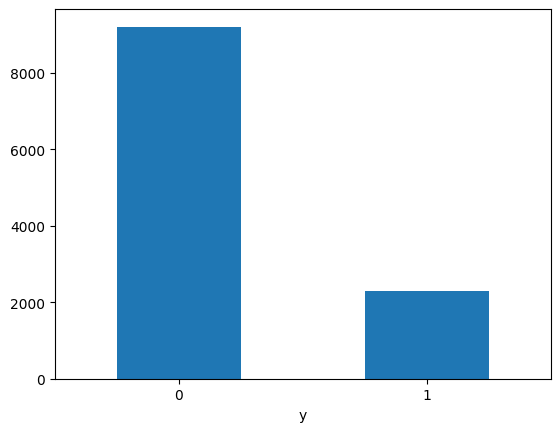

In [7]:
data["y"].value_counts().plot(kind="bar",rot=0) # inbalanced class problem

Upon analyzing the class distribution, we observe a clear class imbalance, with significantly fewer seizure cases compared to non-seizure samples. This imbalance can introduce challenges in model training, as machine learning algorithms often favor the majority class, leading to poor sensitivity in detecting seizures. Additionally, traditional performance metrics like accuracy may be misleading, as a model predicting mostly non-seizure cases could still achieve high accuracy while failing to correctly identify seizure events.  

## Time Series Visualization

To gain a better understanding of the dataset, we will examine random samples from both the seizure (`y = 1`) and non-seizure (`y = 0`) classes. This allows us to observe general patterns in the EEG signals and identify any noticeable differences between the two categories. By visualizing these samples, we can better understand the temporal structure of the data and guide later feature extraction.

In [8]:
positive_samples = data[data["y"]==1].sample(5)
negative_samples = data[data["y"]==0].sample(5)

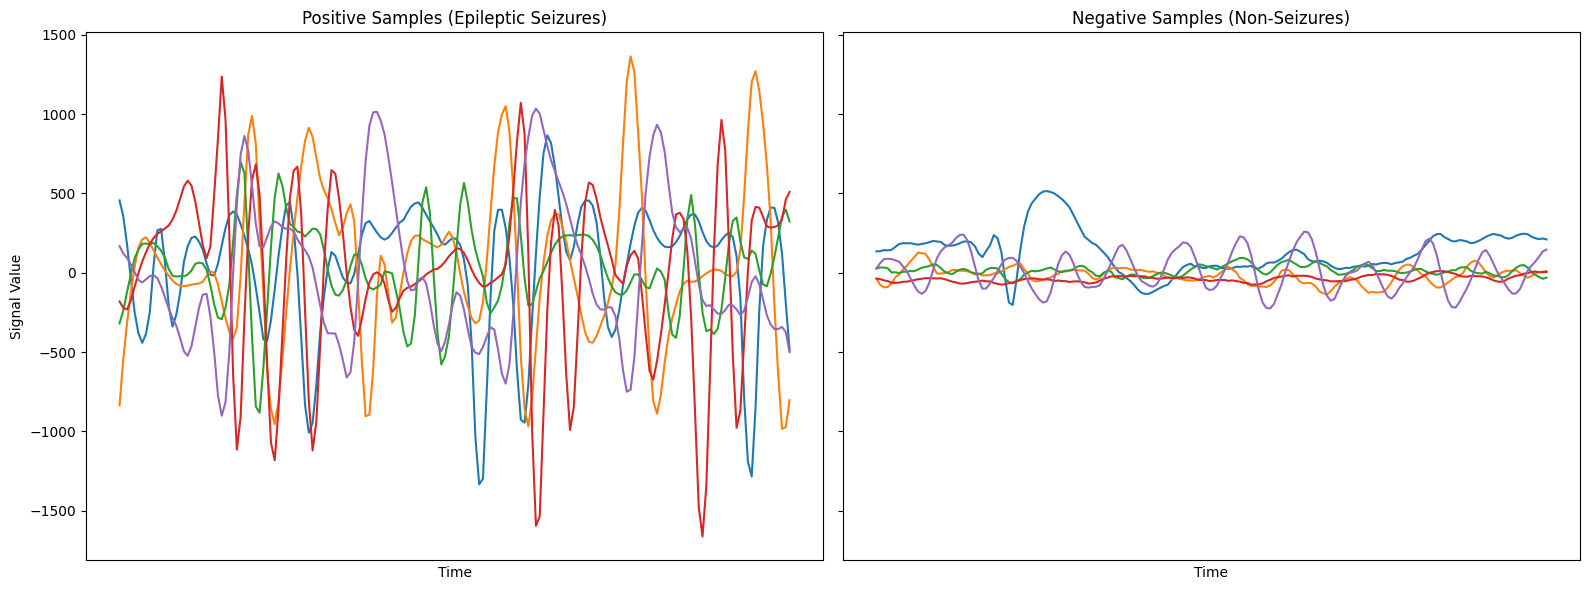

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].plot(positive_samples.drop(columns='y').T)
axes[0].set_title('Positive Samples (Epileptic Seizures)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Signal Value')
axes[0].set_xticks([])  # Remove x-axis labels for clarity

axes[1].plot(negative_samples.drop(columns='y').T)
axes[1].set_title('Negative Samples (Non-Seizures)')
axes[1].set_xlabel('Time')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Notably, the EEG signals from non-seizure examples appear more stable and exhibit lower variance compared to seizure samples, which show more abrupt fluctuations. This suggests that features capturing the variance or volatility of the time series could be valuable for the model, potentially improving its ability to differentiate between seizure and non-seizure activity. Identifying such trends early on helps guide feature selection and engineering for optimal model performance.